# Data analysis 

Variables on the **train.csv**  

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee 20usd fee assigned to responsible judgments
    state_fee - 10usd fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [18]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

import utils

df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 

#### Missing values:

In [16]:
for i in df:
    nas_col = len(df)- df[i].count()
    if nas_col>0:
        print("{}: {} NaN values".format(i,nas_col))

violator_name: 34 NaN values
violation_zip_code: 250306 NaN values
mailing_address_str_number: 3602 NaN values
mailing_address_str_name: 4 NaN values
state: 93 NaN values
zip_code: 1 NaN values
non_us_str_code: 250303 NaN values
hearing_date: 12491 NaN values
fine_amount: 1 NaN values
payment_date: 209193 NaN values
collection_status: 213409 NaN values
grafitti_status: 250305 NaN values
compliance: 90426 NaN values


### Preliminary features selection: 

To avoid leaking the target itself as feature Variables that somehow contain direct information whether the ticket is compliant are not considered (compliance_detail, payment_date, payment_status, etc). Agency and inspector are not considered. The Following variables seem  a reasonable starting choice of features: 
- "violation_street_name",
- "ticket_issued_date",
- "hearing_date",
- "disposition",
- "fine_amount",
- "discount_amount",
- "judgment_amount", 
- "compliance" (target)

In [17]:
preliminary_variables = ["violation_street_name","ticket_issued_date","hearing_date","disposition", "fine_amount","discount_amount", "judgment_amount", "compliance"]

#### Target distribution

In [5]:
df1= df[ preliminary_variables ].copy()
df1["compliance"].astype("category",inplace=True)

print("initial number of tickets: {}".format(len(df1)))
df1.dropna(inplace=True)
print("after droping Nan values: {}".format(len(df1)))
#df1.describe()

initial number of tickets: 250306
after droping Nan values: 159653


<IPython.core.display.Javascript object>


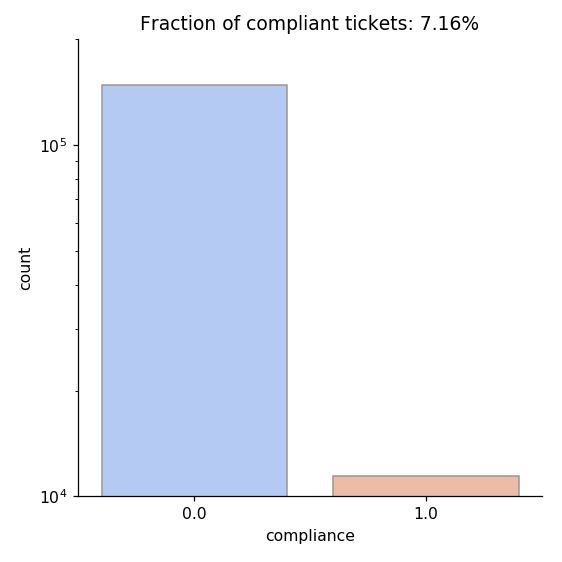

In [6]:
sns.catplot(x="compliance", kind="count", edgecolor=".6", data=df1,palette='coolwarm')
plt.gca().set_title("Fraction of compliant tickets: {:0.2f}%".format( 100*sum(df1.compliance)/len(df1) ))
plt.gca().set_yscale('log')
plt.gca().set_ylim([1e4,2e5])
plt.tight_layout()

## Fine amounts and discounts:

It is reasonable to guess that a discount on a fine may pursue someone to pay it. Lets check the distribution of discount value for *compliants* and *non-compliants*:

<IPython.core.display.Javascript object>


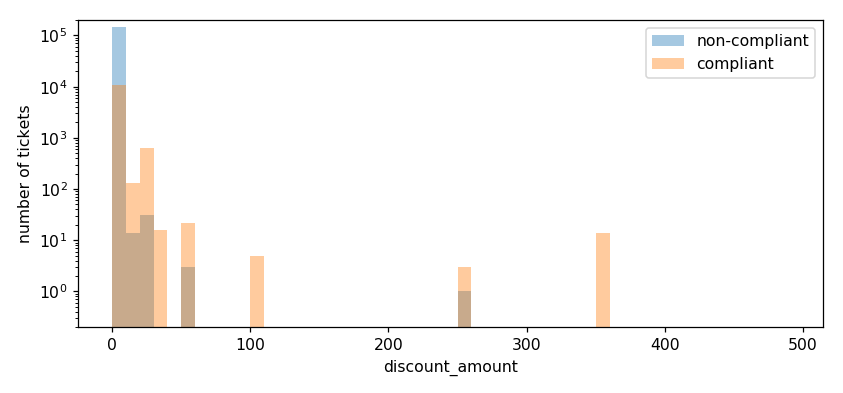

In [4]:
fig1= plt.figure(figsize=(7.5,3.5))
for i,j in [(0,"non-compliant"),(1,"compliant")]:
        data = df1[df1["compliance"]==i]
        sns.distplot(data["discount_amount"],label=j,hist=True,norm_hist=False,kde=False,bins=range(0,500,10))
plt.gca().set_yscale("log")
plt.gca().set_ylim([2e-1,2e5])
plt.gca().set_ylabel("number of tickets")
plt.legend()
plt.tight_layout()

In [7]:
av_discount_non_comp = df1.where( df1["compliance"]==0.0)["discount_amount"].agg(np.mean)
av_discount_comp     = df1.where( df1["compliance"]==1.0)["discount_amount"].agg(np.mean)
print("averages discount compliant tickets: {:0.3f}".format(av_discount_comp))
print("averages discount non-compliant tickets: {:0.3f}".format(av_discount_non_comp))

averages discount compliant tickets: 2.224
averages discount non-compliant tickets: 0.009


The average discounts are not very significantly different, but distributions have a difference: almost all the non-compliant tickets have no discount, in contrast, there is  a *tail* of tickets with discounts the case of compliant tickets. Let's see now the normalized distribution of *fine* and *judgement amounts*, distinguished again by compliance status:

<IPython.core.display.Javascript object>


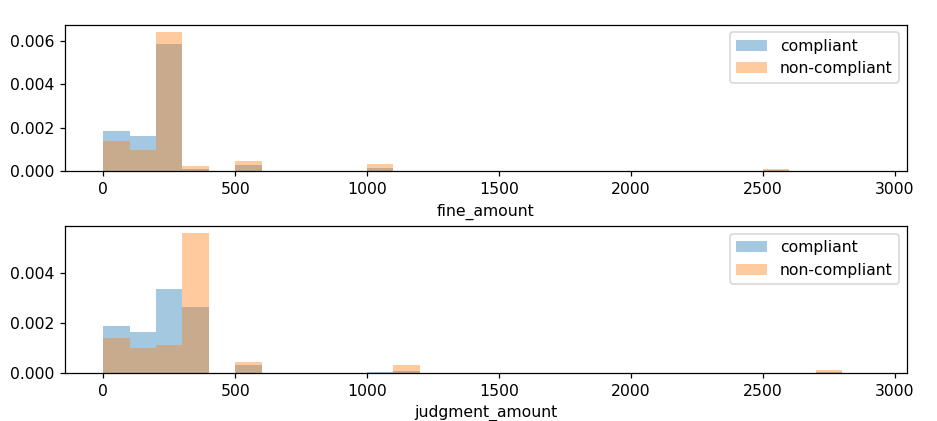

In [5]:
fig22, _ = plt.subplots(2,1,figsize=(8,1.7*2)) 
plt.tight_layout()
for i,var in enumerate(["fine_amount","judgment_amount"]):
    axii=plt.subplot(2,1,i+1)
    for i,j in [(1,"compliant"),(0,"non-compliant")]:
        data = df1[df1["compliance"]==i]
        #sns.kdeplot(data[var],label=j,gridsize=2500,clip=(-10,800))
        sns.distplot(data[var],label=j,hist=True,norm_hist=True,kde=False,bins=range(0,3000,100))
    plt.legend()

The *fine_amount* distributions are rather similar, but the not the *judgement_amount* ones. The distribution of non-compliant tickets peaking at a higher judgement_amount in comparison to the compliant case.

## Waiting time between hearing and ticket issuing:
It is reasonable to think that the time it takes from the point when the fine was issued to the date of the hearing may influence the compliance of the fine:

<IPython.core.display.Javascript object>


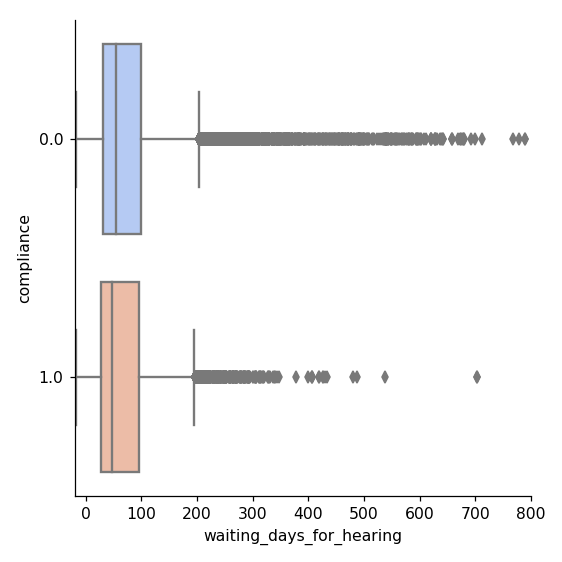

In [6]:
# time interval between hearing and ticket issued date
df1["ticket_issued_date"] = pd.to_datetime(df1["ticket_issued_date"]) #df1["ticket_issued_date"].astype("datetime64[D]")
df1["hearing_date"]=pd.to_datetime(df1["hearing_date"])
df1["waiting_days_for_hearing"] = df1.hearing_date - df1.ticket_issued_date
df1["waiting_days_for_hearing"] = df1["waiting_days_for_hearing"].apply(lambda x: x.days)
sns.catplot(x='waiting_days_for_hearing',y='compliance', kind="box",data=df1,orient="horizontal",palette="coolwarm")
plt.gca().set_xlim([-20,800])
plt.tight_layout()

- For waiting periods >= than ~200 days there are many more non-compliant than compliant cases 
- The quartiles for both distributions are somehow similar distributed but the means differ, being the mean for  compliant tickets smaller.  
- It makes no sense to have a hearing date before the ticket_issued_date, but both distributions present such values so probably it's an error on the data. Let's see how many of these cases are:

In [8]:
print("tickets where hearing date is before ticket_issued date: {}".format( len(df1[ df1.waiting_days_for_hearing<0])))
df1.drop(df1[ df1.waiting_days_for_hearing<0].index, inplace=True)

tickets where hearing date is before ticket_issued date: 80


<IPython.core.display.Javascript object>


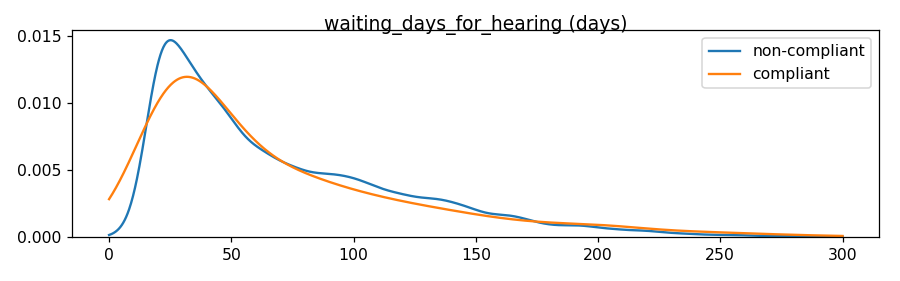

In [9]:
fig4 = plt.figure(figsize=(8,2.5))
for i,j in [(0,"non-compliant"),(1,"compliant")]:
    data = df1[df1["compliance"]==i]
    sns.kdeplot(data["waiting_days_for_hearing"],label=j,gridsize=1500,clip=(0,300))
    plt.gca().set_title("waiting_days_for_hearing (days)",pad=.15)
fig4.tight_layout()

## Disposition categories

The *disposition* variable indicates the reason why the violator person was found responsible. The kernel density estimations of the *judgment_amount* for different disposition categories and different compliance status are shown below.

In [10]:
df1["disposition"] = df1["disposition"].apply(  lambda x: str(x).split("by")[1].strip()  )

<IPython.core.display.Javascript object>


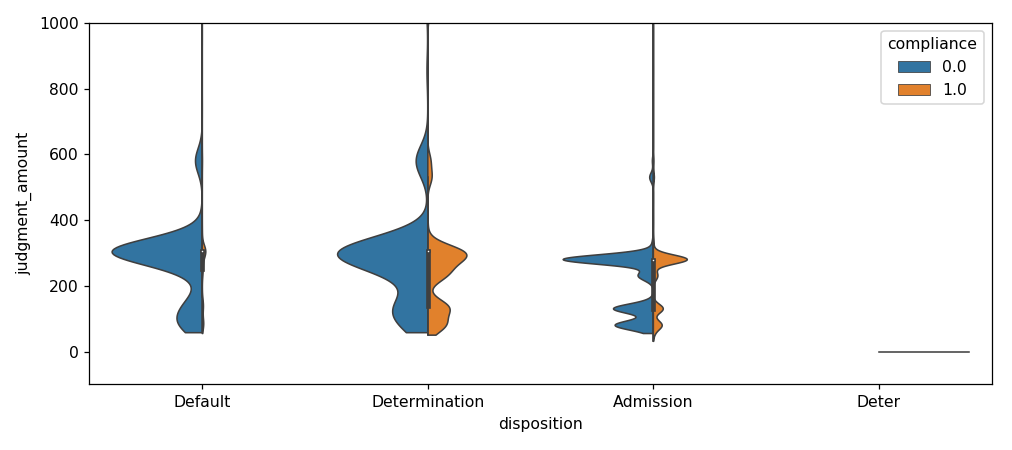

In [11]:
plt.figure(figsize=(9,4))
ax = sns.violinplot(x="disposition", y="judgment_amount", hue="compliance", data=df1,split=True,
                    scale="count",bw=.05,cut=0,gridsize=2500,linewidth=1.0)
ax.set_ylim([-100,1000])
plt.tight_layout()

In [13]:
comp_groups = df1.groupby("compliance").groups
dd = []
for g in comp_groups:
    print("Distribution of Disposition for compliance status: {}".format(g))
    dd_item = df1.loc[comp_groups[g],"disposition"].value_counts()
    dd.append(dd_item)
    print(dd_item)

Distribution of Disposition for compliance status: 0.0
Default          132951
Admission          9922
Determination      5277
Name: disposition, dtype: int64
Distribution of Disposition for compliance status: 1.0
Default          5215
Admission        3734
Determination    2286
Deter             188
Name: disposition, dtype: int64


From the count of disposition cases for each compliance category it is seen that ~95% of cases with responsibility *by Default*  are non compliant, as well as ~72% of *"by Admission"*, and 70% of *"by Determination"*. All the cases with dispostion *by Deter* are compliant.

A complementary information of the fraction of disposition cases per each compliance status is given in the following pie charts:


<IPython.core.display.Javascript object>


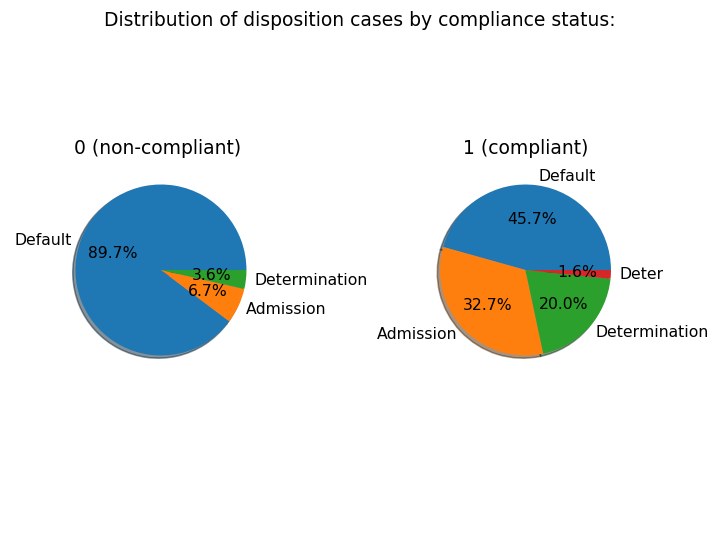

In [14]:
f, _ = plt.subplots(1,2)
f.suptitle("Distribution of disposition cases by compliance status:")
ax1 = plt.subplot(121)
ax1.set_title("0 (non-compliant) ")
plt.pie(dd[0].values, labels=dd[0].index, autopct='%1.1f%%', shadow=True)
plt.tight_layout()
ax2 = plt.subplot(122)
ax2.set_title("1 (compliant)")
plt.pie(dd[1].values, labels=dd[1].index, autopct='%1.1f%%', shadow=True)
plt.tight_layout()

## Geographical distribution

It is perhaps the most obvious guess: A fine compliance can depend on on the place/street where the violiation takes place, as the ubication in a city may underlyingly depend on factors like the economic wealth of the inhabitants. 
In order to visualize the locations,  the `addresses.csv` and `latlons.csv` files must be first joined (`DataFrame.join`). The resulting dataframe is joined then with the dataframe with the ticket compliance info:

In [16]:
df_geoloc = df_geog_info()
df_joined = df1.join(df_geoloc,how="left")
df_joined.dropna(inplace=True)
print("Number of tickets with lat,lon information: {} ({:0.2f}%)".format(len(df_joined), 100*len(df_joined)/len(df1)))

Number of tickets with lat,lon information: 137858 (86.39%)


<IPython.core.display.Javascript object>


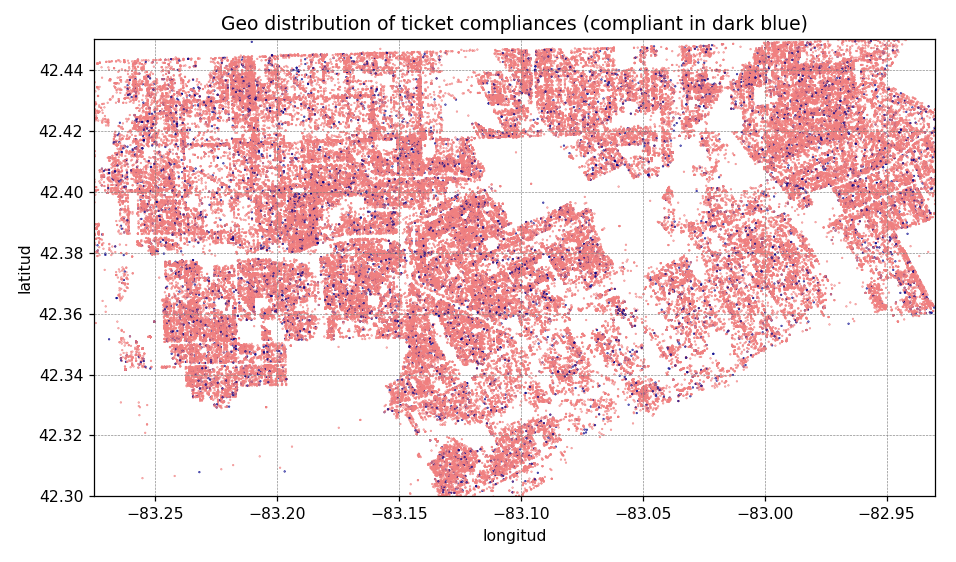

In [17]:
geo_fig = plt.figure(figsize=(8.5,5))
color_code = {0.0:"lightcoral",1.0:"darkblue"}
col = [color_code[i] for i in df_joined["compliance"]]
ax = plt.scatter(df_joined['lon'],df_joined['lat'],c=col,s=0.15,label=col)
ax = plt.gca()
ax.set_xlabel("longitud")
ax.set_ylabel("latitud")
ax.set_title("Geo distribution of ticket compliances (compliant in dark blue)")
ax.grid(True,color='grey', linestyle='--', linewidth=.4)
plt.gca().set_xlim([-83.275,-82.93])
plt.gca().set_ylim([42.3,42.45])
plt.tight_layout()

<IPython.core.display.Javascript object>


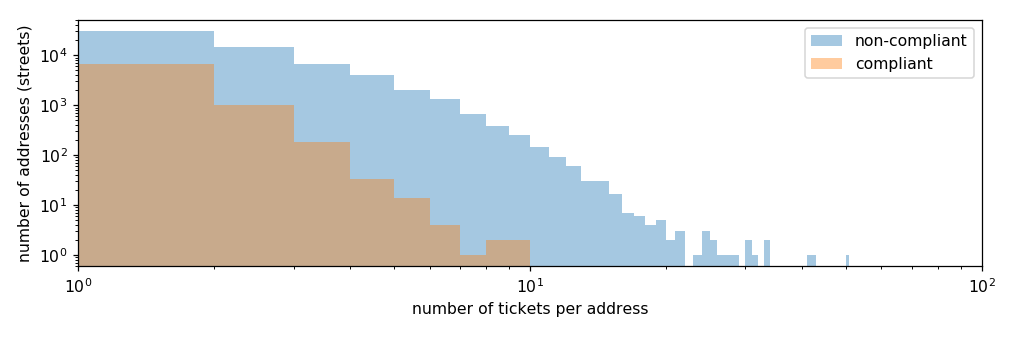

In [18]:
groups_df = df_joined.groupby(["compliance","address"]).groups
compliant_tickets_per_address = [ len(groups_df[g]) for g in groups_df if g[0]==1]
non_compliant_tickets_per_address = [ len(groups_df[g]) for g in groups_df if g[0]==0]

plt.figure(figsize=(9,3))
sns.distplot(non_compliant_tickets_per_address,kde=False,label="non-compliant",bins=range(0,100,1))
sns.distplot(compliant_tickets_per_address,kde=False,label="compliant",bins=range(0,100,1))
plt.legend()
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylabel("number of addresses (streets)")
plt.gca().set_xlabel("number of tickets per address")
plt.gca().set_xlim([1,100])
plt.tight_layout()

The figure with the geographical representation of the data shows that non-compliant tickets are spread over many areas of the city. However, it is not clear how many compliant/non-compliant tickets are conglomerated per address. The last plot shows such distribution (*number of tickets per address*), most of the streets have only one ticket associated but streets with several non-compliant tickets are actually very frequent.

In [19]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137858 entries, 37852 to 284333
Data columns (total 12 columns):
violation_street_name       137858 non-null object
ticket_issued_date          137858 non-null datetime64[ns]
hearing_date                137858 non-null datetime64[ns]
disposition                 137858 non-null object
fine_amount                 137858 non-null float64
discount_amount             137858 non-null float64
judgment_amount             137858 non-null float64
compliance                  137858 non-null float64
waiting_days_for_hearing    137858 non-null int64
lat                         137858 non-null float64
lon                         137858 non-null float64
address                     137858 non-null object
dtypes: datetime64[ns](2), float64(6), int64(1), object(3)
memory usage: 13.7+ MB
